In [3]:
# general import statements
import pandas as pd
import numpy as np
from os import sep
import matplotlib.pyplot as plt

# importing statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# importing stargeazer
from stargazer.stargazer import Stargazer

# importing Synthetic Control Methods APIs
from SyntheticControlMethods import Synth
from SyntheticControlMethods import DiffSynth

In [4]:
# setting display option to always show all columns of given dataframe
pd.set_option('display.max_columns', None)

# Overview

This Jupyter Notebook script contains (almost) all code run for the assignment 'Income, Happiness and the Disutility from Inequality'. It is structured in a way that presents the data in the same sequence as the paper itself, meaning that it has the following sequence:
- Creating multiple linear regression output
- Plotting gini coefficient per country
- Implementing Synthetic Control Method (for which an extra 'Stata' document can be found in the submission folder, which includes the RMSE, Unit Weights, and Predictor Balance in addition to the plot)
- Plotting absolute and relative income frequency alongside their log transformations
- Plotting unemployment rate per country
- plotting government expenditure per country

For simplicity, all data-wrangling work has been omitted from this document. All imported dataframes are the result of data-wrangling operations done on the World Values Survey (Inglehart et al. 2015) and World Development Indicators (World Bank). Further specification on the included variables can be found in the paper itself. Please note that for the synthetic control method, and extra document, called 'Stata_Code.pdf', has been attached which includes further information about the implementation and results of the synthetic control method in Stata.

# Creating regression DataFrame and Output

This section constructs the three regression samples and runs a multiple linear regression model for all. It also presents the output via stargazer to be transformed into latex code.

In [5]:
regression_df = pd.read_csv('regression.csv')
poor_wvs = regression_df[regression_df['ln_abs_inc'] <= 10.2]
rich_wvs = regression_df[regression_df['ln_abs_inc'] > 10.2]

In [6]:
lm_full = smf.ols("satisfaction ~ ln_abs_inc + ln_rel_inc + sex + age + age2 + rep_health + unemp + retired + married + kids + unemp_rate + emissions + edu_exp + health_exp + gini + C(Code)", regression_df).fit()
lm_poor = smf.ols("satisfaction ~ ln_abs_inc + ln_rel_inc + sex + age + age2 + rep_health + unemp + retired + married + kids + C(Code) + unemp_rate + emissions + edu_exp + health_exp + gini", poor_wvs).fit()
lm_rich = smf.ols("satisfaction ~ ln_abs_inc + ln_rel_inc + sex + age + age2 + rep_health + unemp + retired + married + kids + C(Code) + unemp_rate + emissions + edu_exp + health_exp + gini", rich_wvs).fit()

In [21]:
stargazer_country = Stargazer([lm_full, lm_poor, lm_rich])

stargazer_country.add_line('Country Dummies',["Yes","Yes","Yes"])
stargazer_country.covariate_order(['ln_abs_inc','ln_rel_inc',
                                   'sex','age','age2',
                                   'rep_health','unemp',
                                   'retired','married','kids',
                                   'unemp_rate','emissions',
                                   'edu_exp','health_exp',
                                   'gini'])
stargazer_country.rename_covariates({'ln_abs_inc': 'ln(abs_inc)','sex[T.1]':'female','ln_rel_inc':'ln(rel_inc)','ln_abs_inc:ln_rel_inc':'interaction','C(Code)[T.CYP]':'Cyrpus','C(Code)[T.DEU]':'Germany','C(Code)[T.ESP]':'Spain','C(Code)[T.FIN]':'Finland','C(Code)[T.FRA]':'France','C(Code)[T.GBR]':'United Kingdom','C(Code)[T.ITA]':'Italy','C(Code)[T.NLD]':'Netherlands','C(Code)[T.NOR]':'Norway','C(Code)[T.SWE]':'Sweden','ln_gdp_cap':'ln(gdp_cap)'})

stargazer_country.title("Full vs Rich vs Poor Model")
stargazer_country.custom_columns(['Full', 'Poor', 'Rich'], [1,1,1])
stargazer_country.show_model_numbers(False)
stargazer_country.significant_digits(6)

stargazer_country

# print(stargazer_country).to_latex()

In [24]:
print(stargazer_country.render_latex())

\begin{table}[!htbp] \centering
  \caption{Full vs Rich vs Poor Model}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & \multicolumn{1}{c}{Full} & \multicolumn{1}{c}{Poor} & \multicolumn{1}{c}{Rich}  \\
\hline \\[-1.8ex]
 ln(abs_inc) & 0.400918$^{***}$ & 0.383097$^{***}$ & 0.408906$^{***}$ \\
  & (0.023671) & (0.082865) & (0.059072) \\
 ln(rel_inc) & 0.125634$^{***}$ & 0.349355$^{***}$ & 0.033500$^{}$ \\
  & (0.039940) & (0.093691) & (0.063871) \\
 sex & 0.124315$^{***}$ & 0.134490$^{***}$ & 0.119598$^{***}$ \\
  & (0.031076) & (0.050755) & (0.037956) \\
 age & -0.039435$^{***}$ & -0.043340$^{***}$ & -0.032817$^{***}$ \\
  & (0.005830) & (0.008654) & (0.007901) \\
 age2 & 0.000429$^{***}$ & 0.000456$^{***}$ & 0.000388$^{***}$ \\
  & (0.000061) & (0.000089) & (0.000084) \\
 rep_health & -0.737783$^{***}$ & -0.811428$^{***}$ & -0.650643$^{***}$ \\
  & (0.020107) & (0.031822) & (0

# Creating Gini DataFrame and Graphic

This section imports and plots the gini coefficient data per country.

In [6]:
# loading gini dataframe
gini_df = pd.read_csv('gini.csv')

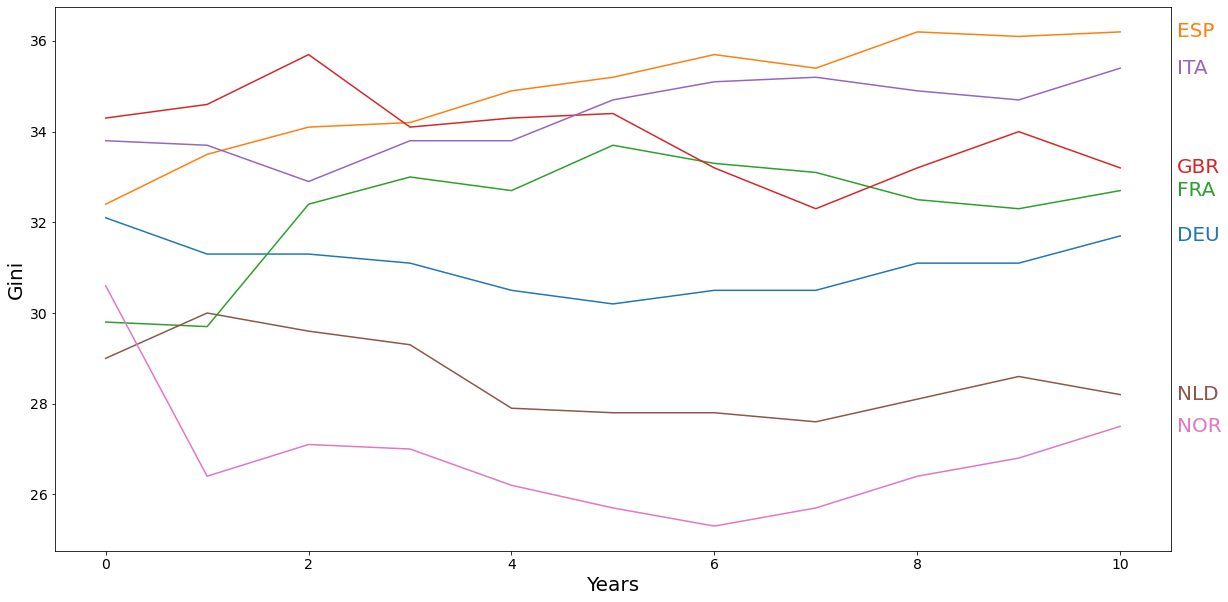

In [7]:
# plotting gini data per country
figure2 = plt.rcParams["figure.figsize"] = [20,10]
ax = gini_df.plot(legend=None)
# ax.set_title("Figure 2: Mobility during Corona",fontsize=20)
plt.xlabel("Years",fontsize=20)
plt.ylabel("Gini",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for line, name in zip(ax.lines, gini_df.columns.to_list()):
    yy = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,yy), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=20, va="center")

plt.show()

# Creating Synthetic Control DataFrame and Graphic

The following section loads the dataframe used for the synthetic control method, performs the synthetic control method as well as plotting the results. Unit weights and predictor balance have been extracted from the synthetic control method module within Stata, for which the results and input code can be found in the 'Stata_Code.pdf' file.

In [8]:
# loading dataframe for synthetic control on spain
spain_df = pd.read_csv('sc_esp.csv')

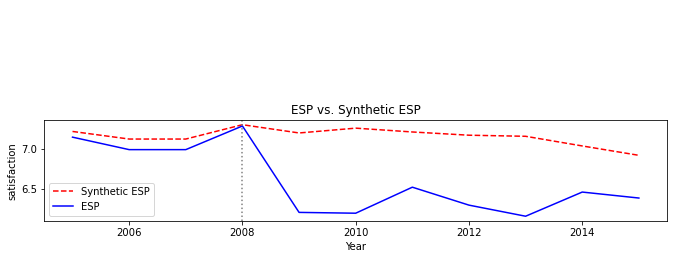

In [14]:
# constructing synthetic control and plotting output
sc_esp = Synth(spain_df, "satisfaction", "Code", "Year", 2009, "ESP")
sc_1 = sc_esp.plot(["original"], treated_label="ESP", 
            synth_label="Synthetic ESP", treatment_label="Inequality growth",figsize=(10,15))

# Creating Income Frequency Graphics

The following graphs present Appendix 2 in the Paper. They show the frequency of absolute income and relative income as well as their log transformations. This is used to justify the use of log transofmration of both variables in the multiple linear regression of the paper.

In [ ]:
# loading the raw regression dataframe
pre_regression_df = pd.read_csv('pre_regression.csv')

In [ ]:
# plotting absolute and log absolute income frequency
n, bins, patches = plt.hist(x=pre_regression_df['Abs Income'], bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Income',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
maxfreq = n.max()
plt.show()


n, bins, patches = plt.hist(x=pre_regression_df['log Abs Income'], bins=20, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('log(Income)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
maxfreq = n.max()
plt.show()

In [ ]:
# plotting relative and log relative income frequency
n, bins, patches = plt.hist(x=pre_regression_df['Rel Income Median'], bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Relative Income',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
# plt.title('Income Frequency')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
maxfreq = n.max()
plt.show()


n, bins, patches = plt.hist(x=pre_regression_df['log Rel Income Median'], bins=10, color='#0504aa', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('log(Relative Income)',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
# plt.title('Income Frequency')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
maxfreq = n.max()
plt.show()

# Creating Government Expenditure DataFrame and Graphic

This section loads and plots the government expenditure per country in 2010 USD.

In [10]:
# loading government expenditure dataframe
expenditure_df = pd.read_csv('expenditure.csv')

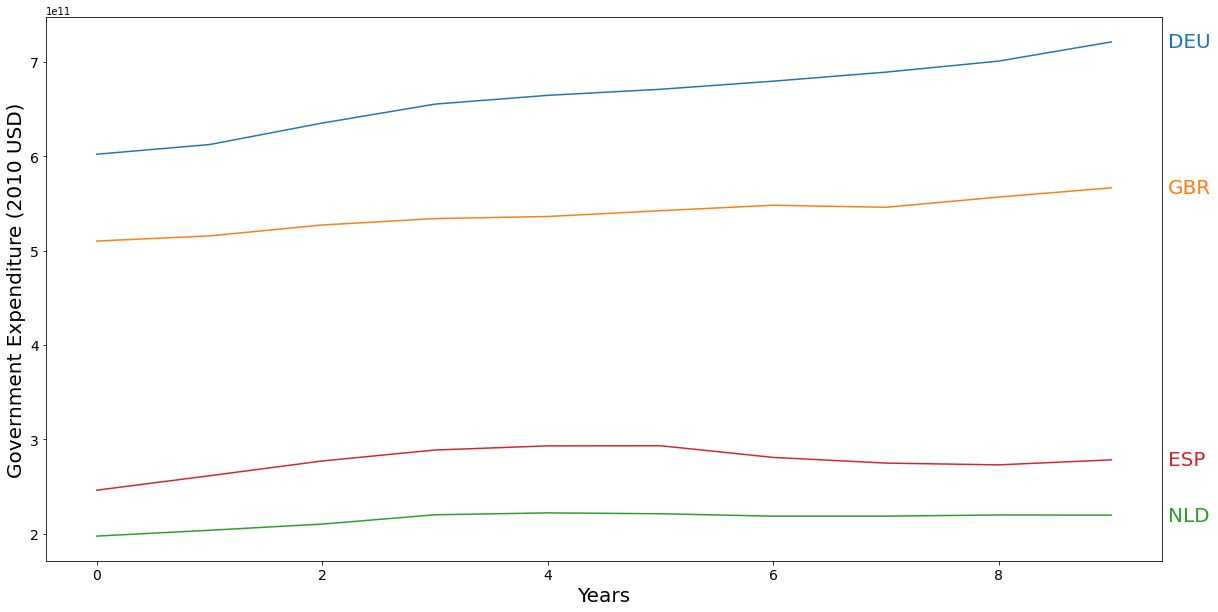

In [11]:
# plotting government expenditure coefficient per country
figure2 = plt.rcParams["figure.figsize"] = [20,10]
ax = expenditure_df.plot(legend=None)
# ax.set_title("Figure 2: Mobility during Corona",fontsize=20)
plt.xlabel("Years",fontsize=20)
plt.ylabel("Government Expenditure (2010 USD)",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for line, name in zip(ax.lines, expenditure_df.columns.to_list()):
    yy = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,yy), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=20, va="center")

plt.show()

# Create Unemployment DataFrame and Graphic

This section loads and plots the unemployment data per country.

In [12]:
# loading unemployment dataframe
unemp_df = pd.read_csv('unemp.csv')

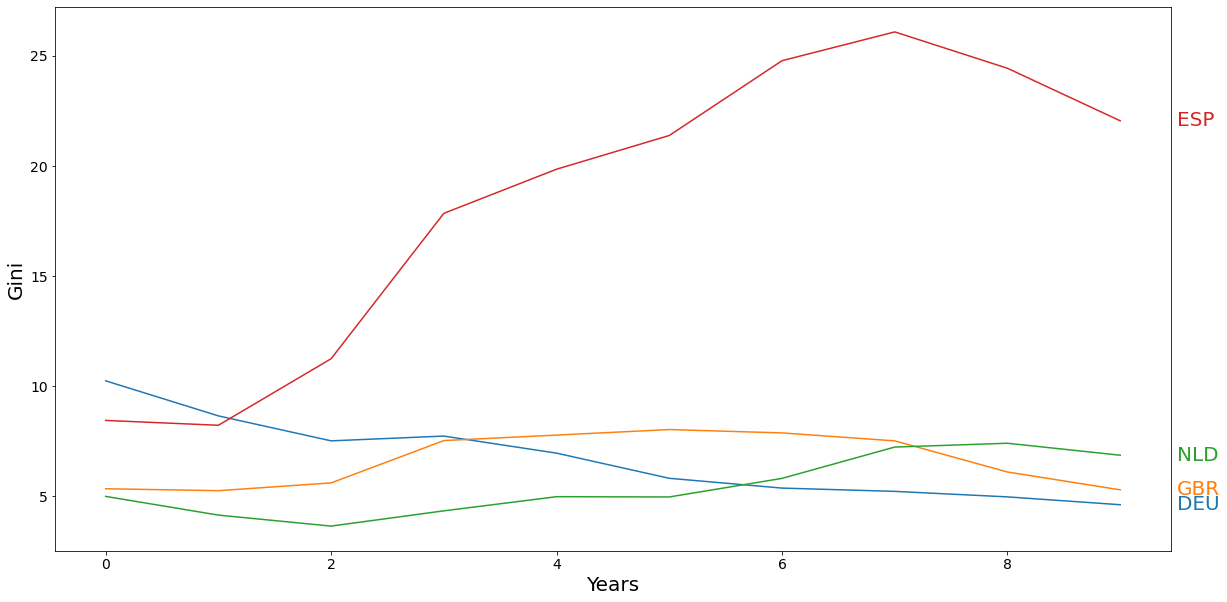

In [13]:
# plotting unemployment per country
figure2 = plt.rcParams["figure.figsize"] = [20,10]
ax = unemp_df.plot(legend=None)
# ax.set_title("Figure 2: Mobility during Corona",fontsize=20)
plt.xlabel("Years",fontsize=20)
plt.ylabel("Gini",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

for line, name in zip(ax.lines, unemp_df.columns.to_list()):
    yy = line.get_ydata()[-1]
    ax.annotate(name, xy=(1,yy), xytext=(6,0), color=line.get_color(), 
                xycoords = ax.get_yaxis_transform(), textcoords="offset points",
                size=20, va="center")

plt.show()